# Melanoma_Detection_Assignment 


**Problem statement:**

To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis. Build a multiclass classification model using a custom convolutional neural network in TensorFlow. 

The dataset consists of 2357 images of malignant and benign oncological diseases, which were formed from the International Skin Imaging Collaboration (ISIC). All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant.

The data set contains the following diseases:

- Actinic keratosis
- Basal cell carcinoma
- Dermatofibroma
- Melanoma
- Nevus
- Pigmented benign keratosis
- Seborrheic keratosis
- Squamous cell carcinoma
- Vascular lesion Vascular lesion

## Solution Plan:

- Data Reading/Data Understanding
- Dataset Creation
- Dataset visualisation
- Model Building & training
- Chose an appropriate data augmentation strategy to resolve underfitting/overfitting
- Model Building & training on the augmented data
- Class distribution
- Handling class imbalances: with Augmentor[https://augmentor.readthedocs.io/en/master/] library.
- Model Building & training on the rectified class imbalance data


In [34]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.models import Sequential

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Import Data and Pre-process it

In [2]:
batch_size = 32
input_image_height = 180
input_image_width = 180

training_data_dir = 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/'
testing_data_dir = 'Skin cancer ISIC The International Skin Imaging Collaboration/Test/'

In [3]:
#?tf.keras.preprocessing.image_dataset_from_directory

In [4]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    training_data_dir,
    labels='inferred', seed=100,
    validation_split=0.2,
    subset='training',
    image_size=(input_image_height, input_image_width),
    batch_size=batch_size)

validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    training_data_dir,
    labels='inferred', seed=100,
    validation_split=0.2,
    subset='validation',
    image_size=(input_image_height, input_image_width),
    batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.
Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [5]:
#print('Image per batch:', len(list(train_ds.as_numpy_iterator())))
print('Images in Train:', len(train_ds.file_paths))
print('Images in Validation:', len(validation_ds.file_paths))

Images in Train: 1792
Images in Validation: 447


In [11]:

class_names = train_ds.class_names
print('The Class Names are: ', class_names)

The Class Names are:  ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


class_names = train_ds.class_names
fig = plt.figure(figsize=(8,3))

for i in range(len(class_names)):
    ax = fig.add_subplot(2,5,1+i, xticks=[], yticks=[])
    im = train_ds[i]
    plt.imshow(im)
plt.show()

In [33]:
[[x for x in train_ds.file_paths if x.startswith("{0}{1}".format(training_data_dir, c))][0] for c in class_names]

['Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis\\ISIC_0029930.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma\\ISIC_0029201.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma\\ISIC_0030870.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma\\ISIC_0010278.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus\\ISIC_0000321.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis\\ISIC_0026923.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis\\ISIC_0010971.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma\\ISIC_0026720.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion\\ISIC_0033817.jpg']

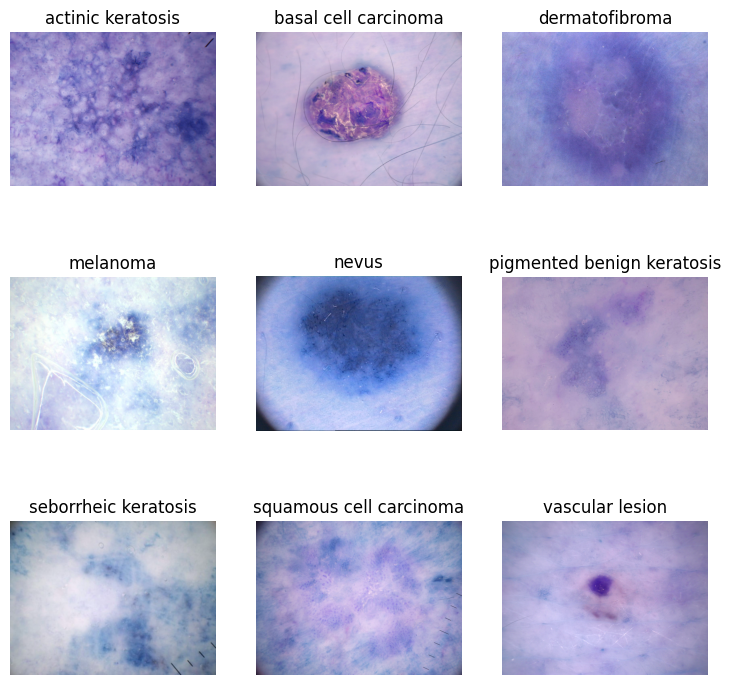

In [47]:
class_names = train_ds.class_names
fig = plt.figure(figsize=(9,9))

for each_class in range(len(class_names)):
    fig_path = [x for x in train_ds.file_paths if x.startswith("{0}{1}".format(training_data_dir, class_names[each_class]))][0]
    #print(fig_path)
    ax = plt.subplot(3, 3, each_class+1)

    plt.imshow(cv2.imread(fig_path))
    plt.title(class_names[each_class])
    plt.axis("off")
plt.show()

In [ ]:
#?train_ds.take

In [ ]:
#?train_ds.as_numpy_iterator

In [ ]:
#?tf.keras.utils.image_dataset_from_directory

In [ ]:
?train_ds.map

In [16]:
for images, labels in train_ds.map(lambda x, y: (x, y)):
    #for l in labels:
    #    print(l)
    conc_labels = labels[0]+labels[1]
    numpy_data = conc_labels.numpy()
    if(numpy_data == 1):
        print(numpy_data)
    #print(conc_labels.lambda(x: x.numpy()==1))
    #numpy_data.numpy()

1


In [ ]:
train_ds.map(lambda x, y: (x, y)).

In [ ]:
?train_ds.map #.get_single_element

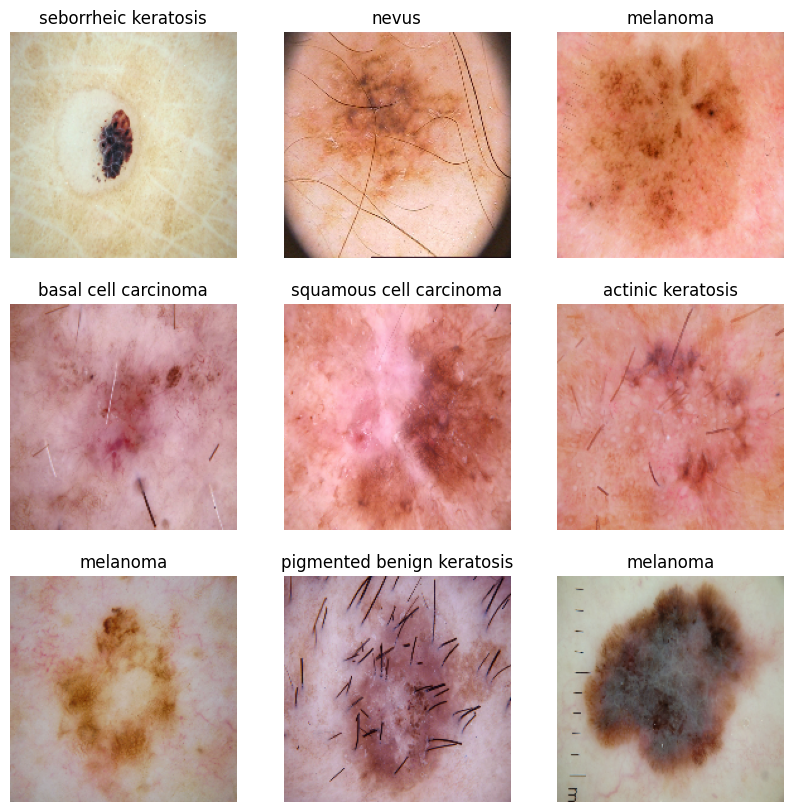

In [18]:
plt.figure(figsize = (10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
?train_ds.take

In [24]:
for k in train_ds.list_files("{0}{1}".format(training_data_dir, class_names[0])):
    print(k.numpy())

b'Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis'


In [32]:
[[x for x in train_ds.file_paths if x.startswith("{0}{1}".format(training_data_dir, c))][0] for c in class_names]

['Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis', 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma', 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma', 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma', 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus', 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis', 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis', 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma', 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion']


['Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis\\ISIC_0029930.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma\\ISIC_0029201.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma\\ISIC_0030870.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma\\ISIC_0010278.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus\\ISIC_0000321.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis\\ISIC_0026923.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis\\ISIC_0010971.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma\\ISIC_0026720.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion\\ISIC_0033817.jpg']